In [35]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel

In [36]:
matches = pd.read_csv(r"C:\Users\nicol\Desktop\git\matches_2021_24.csv", index_col=0)
matches = matches.sort_values(by='date')
matches

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,save%,stp%,cmp%,totdist,crdy,crdr,fls,recov,season,team
0,2021-08-21,18:30,Serie A,Matchweek 1,Sat,Home,W,4.0,0.0,Genoa,...,100.0,0.0,88.4,10336.0,1,0,18.0,43.0,1,Internazionale
1,2021-08-21,20:45,Serie A,Matchweek 1,Sat,Home,L,1.0,3.0,Lazio,...,50.0,0.0,80.8,7851.0,2,0,13.0,47.0,1,Empoli
1,2021-08-21,18:30,Serie A,Matchweek 1,Sat,Away,L,0.0,4.0,Inter,...,50.0,5.3,84.5,6552.0,2,0,7.0,40.0,1,Genoa
0,2021-08-21,20:45,Serie A,Matchweek 1,Sat,Away,W,3.0,1.0,Empoli,...,66.7,0.0,86.1,8854.0,1,0,10.0,45.0,1,Lazio
1,2021-08-21,20:45,Serie A,Matchweek 1,Sat,Home,L,1.0,2.0,Atalanta,...,0.0,0.0,71.4,5616.0,2,0,17.0,77.0,1,Torino
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2024-01-14,20:45,Serie A,Matchweek 20,Sun,Home,W,3.0,1.0,Roma,...,100.0,5.6,86.4,7044.0,2,0,12.0,35.0,3,Milan
21,2024-01-14,18:00,Serie A,Matchweek 20,Sun,Away,D,2.0,2.0,Fiorentina,...,66.7,0.0,71.9,3297.0,1,0,13.0,48.0,3,Udinese
29,2024-01-14,18:00,Serie A,Matchweek 20,Sun,Home,D,2.0,2.0,Udinese,...,66.7,0.0,83.5,9431.0,1,0,14.0,44.0,3,Fiorentina
27,2024-01-15,20:45,Serie A,Matchweek 20,Mon,Home,W,5.0,0.0,Frosinone,...,100.0,0.0,80.4,7301.0,0,0,11.0,69.0,3,Atalanta


In [37]:
del matches["comp"]
del matches["notes"]

In [38]:
## Curiosity: modules used by teams during the last 3 years 
count_values = matches['formation'].value_counts()
count_values

formation
4-3-3         403
3-5-2         368
3-4-3         355
4-2-3-1       341
3-4-1-2       125
4-3-1-2        89
4-4-2          60
3-5-1-1        38
4-3-2-1        32
4-1-4-1        30
3-1-4-2        26
5-3-2          16
4-4-1-1        14
4-1-2-1-2◆      8
5-4-1           7
4-1-3-2         5
4-5-1           3
Name: count, dtype: int64

In [42]:
## I create 3 columns where I enter defenders, midfielders and forwards that
## each team used for each match. They will not be used for later analysis yet.  

def estrai_numeri(formation):
    # Rimuovi il carattere "◆" (rombo) dalla formazione
    formation = formation.replace('◆', '')
    
    numeri = formation.split("-")
    
    if len(numeri) == 3:
        nDef = int(numeri[0])
        nCen = int(numeri[1])
        nAtt = int(numeri[2])
    elif len(numeri) == 4:
        nDef = int(numeri[0])
        if numeri[1] == '1':
            nCen = int(numeri[1]) + int(numeri[2])
            nAtt = int(numeri[3])
        else:
            nCen = int(numeri[1])
            nAtt = int(numeri[2]) + int(numeri[3])
    elif len(numeri) == 5:
        nDef = int(numeri[0])
        nCen = int(numeri[1])
        if numeri[2] == '1':
            nCen += int(numeri[3])
            nAtt = int(numeri[4])
        else:
            nAtt = int(numeri[3]) + int(numeri[4])
    else:
        nDef = nCen = nAtt = 0

    return pd.Series([nDef, nCen, nAtt])



matches[['nDef', 'nCen', 'nAtt']] = matches['formation'].apply(estrai_numeri)

In [43]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Internazionale": "Inter"} 
mapping = MissingDict(**map_values)

In [44]:
## Evaluations extracted from the site FIFA 

forza_mapping_21_22 = {'Milan': 81,'Atalanta': 80,'Internazionale': 82,'Napoli': 80,
    'Hellas Verona': 75,'Fiorentina': 77,'Juventus': 83,'Bologna': 75,
    'Lazio': 79,'Sassuolo': 75,'Genoa': 73, 'Salernitana': 71,'Udinese': 74,'Roma': 79,'Torino': 75,
    'Cagliari': 73,'Empoli': 72,'Spezia': 71,'Sampdoria': 75,
    'Venezia': 72}
forza_mapping_22_23 = {'Milan': 81,'Atalanta': 79,'Internazionale': 83,'Napoli': 81,
    'Hellas Verona': 74,'Fiorentina': 78,'Juventus': 81,'Bologna': 75,
    'Lazio': 79,'Sassuolo': 75,'Monza': 71, 'Salernitana': 72,'Udinese': 74,'Roma': 80,'Torino': 75,
    'Lecce': 73,'Empoli': 73,'Spezia': 73,'Sampdoria': 74,
    'Cremonese': 71}

forza_mapping_23_24 = {'Milan': 82,'Atalanta': 79,'Internazionale': 84,'Napoli': 80,
    'Hellas Verona': 74,'Fiorentina': 79,'Juventus': 81,'Lecce': 74,'Bologna': 76,
    'Frosinone': 74 ,'Lazio': 80,'Sassuolo': 76,'Genoa': 75,
    'Monza': 75,'Salernitana': 73,'Udinese': 75,'Roma': 81,'Torino': 76,
    'Cagliari': 73,'Empoli': 73}

In [45]:
## Dataframe arrangement 

matches = matches.replace('Inter', 'Internazionale')

matches['round'] = matches['round'].str.replace('Matchweek ', '')
matches['round'] = np.where(matches['round'] == 'Relegation tie-breaker', np.nan, matches['round'])
matches['round'] = matches['round'].astype(float)


matches

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,totdist,crdy,crdr,fls,recov,season,team,nDef,nCen,nAtt
0,2021-08-21,18:30,1.0,Sat,Home,W,4.0,0.0,Genoa,1.6,...,10336.0,1,0,18.0,43.0,1,Internazionale,3,5,2
1,2021-08-21,20:45,1.0,Sat,Home,L,1.0,3.0,Lazio,1.2,...,7851.0,2,0,13.0,47.0,1,Empoli,4,1,3
1,2021-08-21,18:30,1.0,Sat,Away,L,0.0,4.0,Internazionale,1.1,...,6552.0,2,0,7.0,40.0,1,Genoa,3,4,3
0,2021-08-21,20:45,1.0,Sat,Away,W,3.0,1.0,Empoli,1.5,...,8854.0,1,0,10.0,45.0,1,Lazio,4,3,3
1,2021-08-21,20:45,1.0,Sat,Home,L,1.0,2.0,Atalanta,1.3,...,5616.0,2,0,17.0,77.0,1,Torino,3,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2024-01-14,20:45,20.0,Sun,Home,W,3.0,1.0,Roma,1.5,...,7044.0,2,0,12.0,35.0,3,Milan,4,3,3
21,2024-01-14,18:00,20.0,Sun,Away,D,2.0,2.0,Fiorentina,1.2,...,3297.0,1,0,13.0,48.0,3,Udinese,3,5,2
29,2024-01-14,18:00,20.0,Sun,Home,D,2.0,2.0,Udinese,1.3,...,9431.0,1,0,14.0,44.0,3,Fiorentina,4,2,4
27,2024-01-15,20:45,20.0,Mon,Home,W,5.0,0.0,Frosinone,3.7,...,7301.0,0,0,11.0,69.0,3,Atalanta,3,4,3


In [46]:
## Allocation of votes to teams for each season

def get_rate(row):
    season = row['season']
    team = row['team']
    if season == 1:
        return forza_mapping_21_22.get(team, None)
    elif season == 2:
        return forza_mapping_22_23.get(team, None)
    elif season == 3:
        return forza_mapping_23_24.get(team, None)
    else:
        return None

matches['rate'] = matches.apply(get_rate, axis=1)


matches

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,crdy,crdr,fls,recov,season,team,nDef,nCen,nAtt,rate
0,2021-08-21,18:30,1.0,Sat,Home,W,4.0,0.0,Genoa,1.6,...,1,0,18.0,43.0,1,Internazionale,3,5,2,82
1,2021-08-21,20:45,1.0,Sat,Home,L,1.0,3.0,Lazio,1.2,...,2,0,13.0,47.0,1,Empoli,4,1,3,72
1,2021-08-21,18:30,1.0,Sat,Away,L,0.0,4.0,Internazionale,1.1,...,2,0,7.0,40.0,1,Genoa,3,4,3,73
0,2021-08-21,20:45,1.0,Sat,Away,W,3.0,1.0,Empoli,1.5,...,1,0,10.0,45.0,1,Lazio,4,3,3,79
1,2021-08-21,20:45,1.0,Sat,Home,L,1.0,2.0,Atalanta,1.3,...,2,0,17.0,77.0,1,Torino,3,4,3,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2024-01-14,20:45,20.0,Sun,Home,W,3.0,1.0,Roma,1.5,...,2,0,12.0,35.0,3,Milan,4,3,3,82
21,2024-01-14,18:00,20.0,Sun,Away,D,2.0,2.0,Fiorentina,1.2,...,1,0,13.0,48.0,3,Udinese,3,5,2,75
29,2024-01-14,18:00,20.0,Sun,Home,D,2.0,2.0,Udinese,1.3,...,1,0,14.0,44.0,3,Fiorentina,4,2,4,79
27,2024-01-15,20:45,20.0,Mon,Home,W,5.0,0.0,Frosinone,3.7,...,0,0,11.0,69.0,3,Atalanta,3,4,3,79


In [47]:
# PCA: THEORY EXPLANATION ON README. 
## I am using pca to reduce the size of the following columns 

# !!! for a correct prediction we will use the pre-match statistics for each match and for each team!

# I calculate the average of the previous 3 matches of each match and replace the value measured in 

# that match with this average.Having done this I will calculate the pca 
cols= ["poss", "sh", "sot", "sot%", 
                       "dist", "g/sot" , "g-xg",
                       "save%", "stp%", "cmp%", 
                      "totdist", "fls", "recov"];

new_cols = [f"{col}_rolling" for col in cols]


matches.sort_values(by="date", inplace=True)

# Checking results 
grouped_data = matches.groupby('team')

grouped_data.get_group('Atalanta')[cols]

,poss,sh,sot,sot%,dist,g/sot,g-xg,save%,stp%,cmp%,totdist,fls,recov
0,52.0,7.0,2.0,28.6,14.9,1.00,1.3,85.7,0.0,72.1,5952.0,13.0,61.0
1,59.0,22.0,3.0,13.6,20.0,0.00,-0.9,100.0,9.1,79.4,8113.0,11.0,77.0
2,55.0,12.0,4.0,33.3,10.7,0.00,-1.2,100.0,0.0,83.5,8544.0,13.0,48.0
4,58.0,10.0,3.0,30.0,15.6,0.33,-0.6,100.0,9.1,82.9,7635.0,13.0,57.0
5,48.0,14.0,5.0,35.7,16.9,0.40,0.1,0.0,5.9,80.4,6906.0,16.0,62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,51.0,20.0,11.0,55.0,18.2,0.36,2.1,66.7,0.0,79.0,7753.0,9.0,67.0
22,40.0,12.0,2.0,16.7,15.5,0.00,-1.2,0.0,28.6,77.2,5935.0,14.0,50.0
23,62.0,17.0,3.0,17.6,14.5,0.33,-0.1,100.0,7.1,79.3,8517.0,10.0,56.0
25,44.0,8.0,2.0,25.0,12.9,0.50,0.3,100.0,0.0,76.4,5677.0,14.0,52.0


In [48]:
## Calculation of averages 

def replace_values(group, cols):
    if not group.empty and len(group) >= 3:
        # Applica rolling dalla quarta riga in poi
        group = group.reset_index(drop=True)
        
        group.loc[0, cols]= group.loc[0,cols]
        
        group.loc[1,cols]= group.loc[1,cols]
        
        group.loc[3:, cols] = group.loc[:,cols].shift(1).rolling(window=3, min_periods = 1).mean().loc[3:]
        
        group.loc[2,cols]= group.loc[:1,cols].mean()

    return group


grouped_data = matches.groupby('team')


rolling_data = grouped_data.apply(lambda group: replace_values(group, cols))

In [49]:
# replacing columns [cols] with averages calculated as described above 

rolling_data.rename(columns=dict(zip(cols, new_cols)), inplace=True)
rolling_data

date   time  round  day venue result   gf   ga  \
team                                                                
Atalanta 0   2021-08-21  20:45    1.0  Sat  Away      W  2.0  1.0   
         1   2021-08-28  18:30    2.0  Sat  Home      D  0.0  0.0   
         2   2021-09-11  20:45    3.0  Sat  Home      L  1.0  2.0   
         3   2021-09-18  20:45    4.0  Sat  Away      W  1.0  0.0   
         4   2021-09-21  20:45    5.0  Tue  Home      W  2.0  1.0   
...                 ...    ...    ...  ...   ...    ...  ...  ...   
Venezia  33  2022-05-01  12:30   35.0  Sun  Away      L  1.0  2.0   
         34  2022-05-05  18:00   20.0  Thu  Away      L  1.0  2.0   
         35  2022-05-08  15:00   36.0  Sun  Home      W  4.0  3.0   
         36  2022-05-14  20:45   37.0  Sat  Away      D  1.0  1.0   
         37  2022-05-22  21:00   38.0  Sun  Home      D  0.0  0.0   

                opponent   xg  ...  crdy  crdr  fls_rolling recov_rolling  \
team                           ...                                          
Atalanta 0        Torino  0.7  ...     2     0    13.000000     61.000000   
         1       Bologna  0.9  ...     2     0    11.000000     77.000000   
         2    Fiorentina  2.2  ...     4     0    12.000000     69.000000   
         3   Salernitana  1.6  ...     4     0    12.333333     62.000000   
         4      Sassuolo  1.9  ...     2     0    12.333333     60.666667   
...                  ...  ...  ...   ...   ...          ...           ...   
Venezia  33     Juventus  0.6  ...     3     0    14.666667     48.666667   
         34  Salernitana  1.1  ...     7     1    13.666667     50.000000   
         35      Bologna  2.8  ...     2     0    13.666667     51.000000   
         36         Roma  0.3  ...     5     1    13.000000     46.333333   
         37     Cagliari  1.0  ...     0     0    13.666667     43.333333   

            season      team nDef  nCen  nAtt  rate  
team                                                 
Atalanta 0       1  Atalanta    3     4     3    80  
         1       1  Atalanta    3     4     3    80  
         2       1  Atalanta    3     4     3    80  
         3       1  Atalanta    3     4     3    80  
         4       1  Atalanta    3     4     3    80  
...            ...       ...  ...   ...   ...   ...  
Venezia  33      1   Venezia    3     4     3    72  
         34      1   Venezia    3     4     3    72  
         35      1   Venezia    3     4     3    72  
         36      1   Venezia    5     3     2    72  
         37      1   Venezia    3     5     2    72  

[1920 rows x 37 columns]

In [50]:
## Normalisation of columns, I explain on the readme why 

scaled_data = rolling_data.copy()

scaled_data[new_cols] = (rolling_data[new_cols] - rolling_data[new_cols].mean()) / rolling_data[new_cols].std()

subset_scaled_data = scaled_data[new_cols]

subset_scaled_data
scaled_data

date   time  round  day venue result   gf   ga  \
team                                                                
Atalanta 0   2021-08-21  20:45    1.0  Sat  Away      W  2.0  1.0   
         1   2021-08-28  18:30    2.0  Sat  Home      D  0.0  0.0   
         2   2021-09-11  20:45    3.0  Sat  Home      L  1.0  2.0   
         3   2021-09-18  20:45    4.0  Sat  Away      W  1.0  0.0   
         4   2021-09-21  20:45    5.0  Tue  Home      W  2.0  1.0   
...                 ...    ...    ...  ...   ...    ...  ...  ...   
Venezia  33  2022-05-01  12:30   35.0  Sun  Away      L  1.0  2.0   
         34  2022-05-05  18:00   20.0  Thu  Away      L  1.0  2.0   
         35  2022-05-08  15:00   36.0  Sun  Home      W  4.0  3.0   
         36  2022-05-14  20:45   37.0  Sat  Away      D  1.0  1.0   
         37  2022-05-22  21:00   38.0  Sun  Home      D  0.0  0.0   

                opponent   xg  ...  crdy  crdr  fls_rolling recov_rolling  \
team                           ...                                          
Atalanta 0        Torino  0.7  ...     2     0     0.119639      1.309264   
         1       Bologna  0.9  ...     2     0    -0.688952      3.684448   
         2    Fiorentina  2.2  ...     4     0    -0.284657      2.496856   
         3   Salernitana  1.6  ...     4     0    -0.149891      1.457713   
         4      Sassuolo  1.9  ...     2     0    -0.149891      1.259781   
...                  ...  ...  ...   ...   ...          ...           ...   
Venezia  33     Juventus  0.6  ...     3     0     0.793466     -0.521608   
         34  Salernitana  1.1  ...     7     1     0.389170     -0.323676   
         35      Bologna  2.8  ...     2     0     0.389170     -0.175227   
         36         Roma  0.3  ...     5     1     0.119639     -0.867989   
         37     Cagliari  1.0  ...     0     0     0.389170     -1.313336   

            season      team nDef  nCen  nAtt  rate  
team                                                 
Atalanta 0       1  Atalanta    3     4     3    80  
         1       1  Atalanta    3     4     3    80  
         2       1  Atalanta    3     4     3    80  
         3       1  Atalanta    3     4     3    80  
         4       1  Atalanta    3     4     3    80  
...            ...       ...  ...   ...   ...   ...  
Venezia  33      1   Venezia    3     4     3    72  
         34      1   Venezia    3     4     3    72  
         35      1   Venezia    3     4     3    72  
         36      1   Venezia    5     3     2    72  
         37      1   Venezia    3     5     2    72  

[1920 rows x 37 columns]

In [51]:
# PCA does not work with null values. 
# Unfortunately, this can happen during scraping. 
# Without loss of generality, null values can be replaced with the average of the column. 
# Let us check how many there are:

missing_values = scaled_data[new_cols].isnull().sum()

# Visualizza eventuali valori NaN rimanenti
print("Missing values after fill:")
print(missing_values)



Missing values after fill:
poss_rolling       0
sh_rolling         0
sot_rolling        0
sot%_rolling       0
dist_rolling       0
g/sot_rolling      2
g-xg_rolling       0
save%_rolling      1
stp%_rolling       0
cmp%_rolling       0
totdist_rolling    0
fls_rolling        0
recov_rolling      0
dtype: int64


In [52]:
## If above are not all zeros then run this part of the code. 



for team_name in scaled_data.index.get_level_values('team').unique():
    
    team_data_new_cols = scaled_data.loc[scaled_data.index.get_level_values('team') == team_name, new_cols]
    
    
    team_data_filled = team_data_new_cols.apply(lambda col: col.fillna(col.mean()), axis=0)
    
    
    scaled_data.loc[scaled_data.index.get_level_values('team') == team_name, new_cols] = team_data_filled
    
missing_values_after_fill = scaled_data[new_cols].isnull().sum()

# Visualizza eventuali valori NaN rimanenti
print("Missing values after fill:")
print(missing_values_after_fill)


## All values should be zero now 

Missing values after fill:
poss_rolling       0
sh_rolling         0
sot_rolling        0
sot%_rolling       0
dist_rolling       0
g/sot_rolling      0
g-xg_rolling       0
save%_rolling      0
stp%_rolling       0
cmp%_rolling       0
totdist_rolling    0
fls_rolling        0
recov_rolling      0
dtype: int64


In [53]:
scaled_data

date   time  round  day venue result   gf   ga  \
team                                                                
Atalanta 0   2021-08-21  20:45    1.0  Sat  Away      W  2.0  1.0   
         1   2021-08-28  18:30    2.0  Sat  Home      D  0.0  0.0   
         2   2021-09-11  20:45    3.0  Sat  Home      L  1.0  2.0   
         3   2021-09-18  20:45    4.0  Sat  Away      W  1.0  0.0   
         4   2021-09-21  20:45    5.0  Tue  Home      W  2.0  1.0   
...                 ...    ...    ...  ...   ...    ...  ...  ...   
Venezia  33  2022-05-01  12:30   35.0  Sun  Away      L  1.0  2.0   
         34  2022-05-05  18:00   20.0  Thu  Away      L  1.0  2.0   
         35  2022-05-08  15:00   36.0  Sun  Home      W  4.0  3.0   
         36  2022-05-14  20:45   37.0  Sat  Away      D  1.0  1.0   
         37  2022-05-22  21:00   38.0  Sun  Home      D  0.0  0.0   

                opponent   xg  ...  crdy  crdr  fls_rolling recov_rolling  \
team                           ...                                          
Atalanta 0        Torino  0.7  ...     2     0     0.119639      1.309264   
         1       Bologna  0.9  ...     2     0    -0.688952      3.684448   
         2    Fiorentina  2.2  ...     4     0    -0.284657      2.496856   
         3   Salernitana  1.6  ...     4     0    -0.149891      1.457713   
         4      Sassuolo  1.9  ...     2     0    -0.149891      1.259781   
...                  ...  ...  ...   ...   ...          ...           ...   
Venezia  33     Juventus  0.6  ...     3     0     0.793466     -0.521608   
         34  Salernitana  1.1  ...     7     1     0.389170     -0.323676   
         35      Bologna  2.8  ...     2     0     0.389170     -0.175227   
         36         Roma  0.3  ...     5     1     0.119639     -0.867989   
         37     Cagliari  1.0  ...     0     0     0.389170     -1.313336   

            season      team nDef  nCen  nAtt  rate  
team                                                 
Atalanta 0       1  Atalanta    3     4     3    80  
         1       1  Atalanta    3     4     3    80  
         2       1  Atalanta    3     4     3    80  
         3       1  Atalanta    3     4     3    80  
         4       1  Atalanta    3     4     3    80  
...            ...       ...  ...   ...   ...   ...  
Venezia  33      1   Venezia    3     4     3    72  
         34      1   Venezia    3     4     3    72  
         35      1   Venezia    3     4     3    72  
         36      1   Venezia    5     3     2    72  
         37      1   Venezia    3     5     2    72  

[1920 rows x 37 columns]

In [54]:
# Add the new columns new_1, new_2, ..., new_6 to the DataFrame
for i in range(1, 7):
    scaled_data[f'new_{i}'] = None

scaled_data

date   time  round  day venue result   gf   ga  \
team                                                                
Atalanta 0   2021-08-21  20:45    1.0  Sat  Away      W  2.0  1.0   
         1   2021-08-28  18:30    2.0  Sat  Home      D  0.0  0.0   
         2   2021-09-11  20:45    3.0  Sat  Home      L  1.0  2.0   
         3   2021-09-18  20:45    4.0  Sat  Away      W  1.0  0.0   
         4   2021-09-21  20:45    5.0  Tue  Home      W  2.0  1.0   
...                 ...    ...    ...  ...   ...    ...  ...  ...   
Venezia  33  2022-05-01  12:30   35.0  Sun  Away      L  1.0  2.0   
         34  2022-05-05  18:00   20.0  Thu  Away      L  1.0  2.0   
         35  2022-05-08  15:00   36.0  Sun  Home      W  4.0  3.0   
         36  2022-05-14  20:45   37.0  Sat  Away      D  1.0  1.0   
         37  2022-05-22  21:00   38.0  Sun  Home      D  0.0  0.0   

                opponent   xg  ...  nDef  nCen  nAtt rate new_1 new_2 new_3  \
team                           ...                                            
Atalanta 0        Torino  0.7  ...     3     4     3   80  None  None  None   
         1       Bologna  0.9  ...     3     4     3   80  None  None  None   
         2    Fiorentina  2.2  ...     3     4     3   80  None  None  None   
         3   Salernitana  1.6  ...     3     4     3   80  None  None  None   
         4      Sassuolo  1.9  ...     3     4     3   80  None  None  None   
...                  ...  ...  ...   ...   ...   ...  ...   ...   ...   ...   
Venezia  33     Juventus  0.6  ...     3     4     3   72  None  None  None   
         34  Salernitana  1.1  ...     3     4     3   72  None  None  None   
         35      Bologna  2.8  ...     3     4     3   72  None  None  None   
         36         Roma  0.3  ...     5     3     2   72  None  None  None   
         37     Cagliari  1.0  ...     3     5     2   72  None  None  None   

             new_4  new_5  new_6  
team                              
Atalanta 0    None   None   None  
         1    None   None   None  
         2    None   None   None  
         3    None   None   None  
         4    None   None   None  
...            ...    ...    ...  
Venezia  33   None   None   None  
         34   None   None   None  
         35   None   None   None  
         36   None   None   None  
         37   None   None   None  

[1920 rows x 43 columns]

In [58]:
## PCA using 6 components
num_components = 6

results_per_team = {}

total_variance_explained = 0 

for team_name, team_data in scaled_data.groupby(level='team'):
    team_data_subset = team_data[new_cols]
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(team_data_subset)
    
    explained_variances = pca.explained_variance_ratio_

    # Insert results into the original DataFrame
    for i in range(num_components):
        col_name = f'new_{i+1}'
        scaled_data.loc[team_data.index, col_name] = principal_components[:, i]

    # Add results to the dictionary
    results_per_team[team_name] = {
        f'new_{i+1}': principal_components[:, i] for i in range(num_components)
    }

# Display the modified scaled_data DataFrame with the new principal component columns
scaled_data


date   time  round  day venue result   gf   ga  \
team                                                                
Atalanta 0   2021-08-21  20:45    1.0  Sat  Away      W  2.0  1.0   
         1   2021-08-28  18:30    2.0  Sat  Home      D  0.0  0.0   
         2   2021-09-11  20:45    3.0  Sat  Home      L  1.0  2.0   
         3   2021-09-18  20:45    4.0  Sat  Away      W  1.0  0.0   
         4   2021-09-21  20:45    5.0  Tue  Home      W  2.0  1.0   
...                 ...    ...    ...  ...   ...    ...  ...  ...   
Venezia  33  2022-05-01  12:30   35.0  Sun  Away      L  1.0  2.0   
         34  2022-05-05  18:00   20.0  Thu  Away      L  1.0  2.0   
         35  2022-05-08  15:00   36.0  Sun  Home      W  4.0  3.0   
         36  2022-05-14  20:45   37.0  Sat  Away      D  1.0  1.0   
         37  2022-05-22  21:00   38.0  Sun  Home      D  0.0  0.0   

                opponent   xg  ...  nDef  nCen  nAtt rate     new_1     new_2  \
team                           ...                                              
Atalanta 0        Torino  0.7  ...     3     4     3   80  1.042486 -4.272156   
         1       Bologna  0.9  ...     3     4     3   80 -2.760177  3.275253   
         2    Fiorentina  2.2  ...     3     4     3   80 -0.858845 -0.498451   
         3   Salernitana  1.6  ...     3     4     3   80 -1.628427 -0.324883   
         4      Sassuolo  1.9  ...     3     4     3   80 -2.371464  1.101452   
...                  ...  ...  ...   ...   ...   ...  ...       ...       ...   
Venezia  33     Juventus  0.6  ...     3     4     3   72 -0.031293  0.428894   
         34  Salernitana  1.1  ...     3     4     3   72  0.253164  0.520844   
         35      Bologna  2.8  ...     3     4     3   72 -0.093164  0.447422   
         36         Roma  0.3  ...     5     3     2   72  0.870685 -0.422997   
         37     Cagliari  1.0  ...     3     5     2   72  1.963949 -0.471135   

                new_3     new_4     new_5     new_6  
team                                                 
Atalanta 0  -1.803107 -1.921861  2.269445 -0.099223  
         1  -0.512572 -1.675064 -0.880966  2.373064  
         2  -1.157839 -1.798462   0.69424   1.13692  
         3  -1.133534 -1.353323 -0.007089 -0.124862  
         4  -1.213016 -0.970753 -0.928484 -0.106655  
...               ...       ...       ...       ...  
Venezia  33 -0.451508 -0.175167 -0.033984 -1.044184  
         34  0.548098  0.555945 -0.969628 -1.108095  
         35  0.366812   1.25956 -0.065459 -0.054158  
         36 -0.003344   1.14943 -0.131722  1.290195  
         37 -0.768647  0.546938 -0.767343  0.999739  

[1920 rows x 43 columns]

In [59]:
## WHY 6 COMPONENTS ? LOOK AT THE EXPLAINED VARIANCE ! 
## IT COULD BE 7, AS WELL 


# Maximum number of desired principal components
max_components = 13

# Create a dictionary to store results for each team
results_per_team = {}

# Create a DataFrame to store explained variance for each principal component and each team
variance_explained_df = pd.DataFrame(columns=[f'Component_{i}' for i in range(5, max_components + 1)])

# Iterate over each team
for team_name, team_data in scaled_data.groupby(level='team'):
    # Select only the 'new_cols' columns for the current team
    team_data_subset = team_data[new_cols]

    # Initialize a DataFrame to store explained variance
    variance_explained_team = pd.DataFrame(index=[team_name])

    # Perform PCA with different numbers of principal components
    for num_components in range(5, max_components + 1):
        pca = PCA(n_components=num_components)
        pca.fit(team_data_subset)

        # Calculate explained variance
        variance_explained = np.sum(pca.explained_variance_ratio_)

        # Store explained variance in the DataFrame
        variance_explained_team.loc[team_name, f'Component_{num_components}'] = variance_explained

    # Add the results to the dictionary
    results_per_team[team_name] = variance_explained_team

    # Add explained variance for each principal component to the main DataFrame
    variance_explained_df = pd.concat([variance_explained_df, variance_explained_team])

# Display the table of explained variance for each team
variance_explained_df


,Component_5,Component_6,Component_7,Component_8,Component_9,Component_10,Component_11,Component_12,Component_13
Atalanta,0.795544,0.864745,0.908594,0.947803,0.971320,0.986927,0.994472,0.998108,1.0
Bologna,0.755694,0.827704,0.887524,0.935856,0.963687,0.982574,0.994249,0.997947,1.0
Cagliari,0.785562,0.870701,0.923784,0.955083,0.976784,0.990606,0.996507,0.998412,1.0
Cremonese,0.831690,0.882702,0.925925,0.959017,0.978627,0.988992,0.997000,0.998605,1.0
Empoli,0.746990,0.825582,0.889749,0.931696,0.966455,0.983726,0.995629,0.998298,1.0
Fiorentina,0.767935,0.841258,0.893633,0.931718,0.966838,0.984236,0.996084,0.998967,1.0
Frosinone,0.928460,0.957304,0.974409,0.986293,0.995556,0.998120,0.999431,0.999760,1.0
Genoa,0.843614,0.892524,0.924572,0.953841,0.977379,0.990212,0.996439,0.998815,1.0
Hellas Verona,0.775745,0.840316,0.886625,0.928931,0.961238,0.983727,0.994874,0.998504,1.0
Internazionale,0.824227,0.877447,0.916111,0.952596,0.976067,0.990671,0.996012,0.998537,1.0


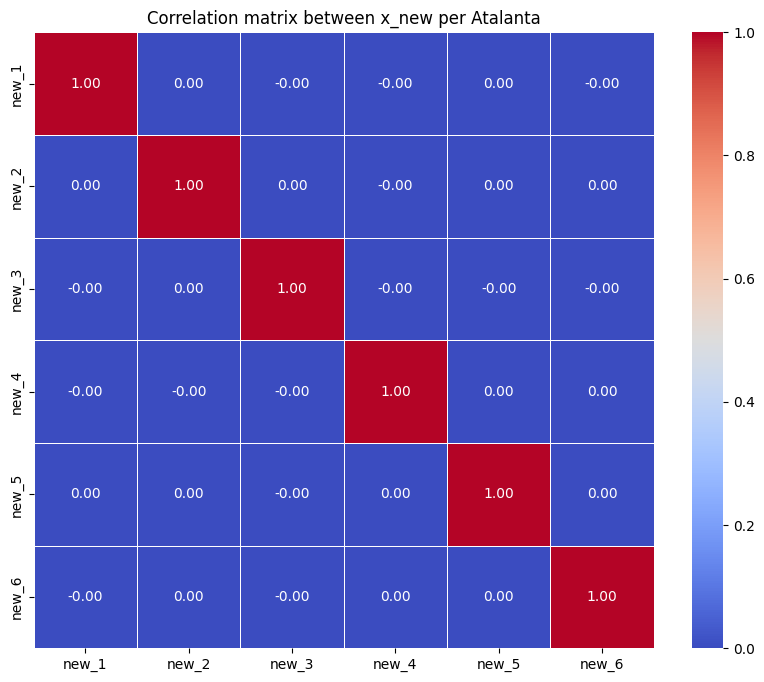

In [60]:
# This technique is effective for unimportant statistics to simplify the work of our algorithm which we will use in the next script. 
# We will use random forest, which requires that variables preferably have zero correlation between them: 
# here is a small demonstration 
atalanta_x_new = scaled_data.query("team == 'Atalanta'")[['new_1', 'new_2', 'new_3', 'new_4', 'new_5', 'new_6']]

correlation_matrix = atalanta_x_new.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation matrix between x_new per Atalanta')
plt.show()

In [61]:
## I delete the previous columns _ 
scaled_data = scaled_data.drop(new_cols, axis=1)
scaled_data

date   time  round  day venue result   gf   ga  \
team                                                                
Atalanta 0   2021-08-21  20:45    1.0  Sat  Away      W  2.0  1.0   
         1   2021-08-28  18:30    2.0  Sat  Home      D  0.0  0.0   
         2   2021-09-11  20:45    3.0  Sat  Home      L  1.0  2.0   
         3   2021-09-18  20:45    4.0  Sat  Away      W  1.0  0.0   
         4   2021-09-21  20:45    5.0  Tue  Home      W  2.0  1.0   
...                 ...    ...    ...  ...   ...    ...  ...  ...   
Venezia  33  2022-05-01  12:30   35.0  Sun  Away      L  1.0  2.0   
         34  2022-05-05  18:00   20.0  Thu  Away      L  1.0  2.0   
         35  2022-05-08  15:00   36.0  Sun  Home      W  4.0  3.0   
         36  2022-05-14  20:45   37.0  Sat  Away      D  1.0  1.0   
         37  2022-05-22  21:00   38.0  Sun  Home      D  0.0  0.0   

                opponent   xg  ...  nDef  nCen nAtt rate     new_1     new_2  \
team                           ...                                             
Atalanta 0        Torino  0.7  ...     3     4    3   80  1.042486 -4.272156   
         1       Bologna  0.9  ...     3     4    3   80 -2.760177  3.275253   
         2    Fiorentina  2.2  ...     3     4    3   80 -0.858845 -0.498451   
         3   Salernitana  1.6  ...     3     4    3   80 -1.628427 -0.324883   
         4      Sassuolo  1.9  ...     3     4    3   80 -2.371464  1.101452   
...                  ...  ...  ...   ...   ...  ...  ...       ...       ...   
Venezia  33     Juventus  0.6  ...     3     4    3   72 -0.031293  0.428894   
         34  Salernitana  1.1  ...     3     4    3   72  0.253164  0.520844   
         35      Bologna  2.8  ...     3     4    3   72 -0.093164  0.447422   
         36         Roma  0.3  ...     5     3    2   72  0.870685 -0.422997   
         37     Cagliari  1.0  ...     3     5    2   72  1.963949 -0.471135   

                new_3     new_4     new_5     new_6  
team                                                 
Atalanta 0  -1.803107 -1.921861  2.269445 -0.099223  
         1  -0.512572 -1.675064 -0.880966  2.373064  
         2  -1.157839 -1.798462   0.69424   1.13692  
         3  -1.133534 -1.353323 -0.007089 -0.124862  
         4  -1.213016 -0.970753 -0.928484 -0.106655  
...               ...       ...       ...       ...  
Venezia  33 -0.451508 -0.175167 -0.033984 -1.044184  
         34  0.548098  0.555945 -0.969628 -1.108095  
         35  0.366812   1.25956 -0.065459 -0.054158  
         36 -0.003344   1.14943 -0.131722  1.290195  
         37 -0.768647  0.546938 -0.767343  0.999739  

[1920 rows x 30 columns]

In [63]:
scaled_data.to_csv(r"C:\Users\nicol\Desktop\git\df_pca.csv")

In [ ]:
#